In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pyscf
from pyscf import gto,dft,scf

In [3]:
# import neuralxc
# from neuralxc.projector.pyscf import get_eri3c as get_mlovlp
import torch
import pyscf
from pyscf import gto,dft,scf

import numpy as np
import scipy
from ase import Atoms
from ase.io import read
from dpyscf.net import * 
from dpyscf.torch_routines import * 
from dpyscf.utils import *
from pyscf.cc import CCSD
from functools import partial
from ase.units import Bohr
import os
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/sebastian/miniconda3/envs/e3nn/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['datetime', 'eig']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [4]:
torch.set_default_dtype(torch.double)

In [5]:
# torch.cuda.current_device()
# torch.cuda.is_available()
# torch.cuda.get_device_name(0)
# torch.set_default_dtype(torch.double)

In [6]:
DEVICE='cpu'

In [58]:
level = 'GGA'
xc = 'c'
ref = 'GGA_C_PBE'

n_hidden =16
if level == 'GGA':
    if xc == 'x':
        local = XC_L(device=DEVICE,n_input=1, n_hidden=n_hidden, spin_scaling=True, use=[1], lob=1.804)
    elif xc == 'c':
        local = C_L(device=DEVICE,n_input=3, n_hidden=n_hidden, use=[2], ueg_limit=True)
elif level == 'MGGA':
    if xc == 'x':
        local = XC_L(device=DEVICE, n_input=2, n_hidden=n_hidden, spin_scaling=True, use=[1, 2], 
                     lob=1.174)
#                      lob =2.17)
    elif xc == 'c':
        local = C_L(device=DEVICE, n_input=4, n_hidden=n_hidden, use=[2,3])
        
ueg = LDA_X()
xc = XC(grid_models=[local], heg_mult=True, level= {'GGA':2, 'MGGA':3}[level])
xc.epsilon = 0
# if xc == 'c':
xc.loge = 1e-5
#     xc.s_gam = 0.01

In [9]:
local.load_state_dict(torch.load('../models/pretrained/pbe/c',map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
def get_mol(atoms, basis='6-311++G**'):
    pos = atoms.positions
    spec = atoms.get_chemical_symbols()
    mol_input = [[s, p] for s, p in zip(spec, pos)]
    try:
        mol = gto.M(atom=mol_input, basis=atoms.info.get('basis',basis),spin=atoms.info.get('spin',0))
    except Exception:
        mol = gto.M(atom=mol_input, basis=atoms.info.get('basis','STO-3G'),spin=atoms.info.get('spin',0))
    return mol 

In [10]:
def get_rhos(rho, spin):
    rho0 = rho[0,0]
    drho = rho[0,1:4] + rho[1:4,0]
    tau = 0.5*(rho[1,1] + rho[2,2] + rho[3,3])

    if spin != 0:
        rho0_a = rho0[0]
        rho0_b = rho0[1]
        gamma_a, gamma_b = torch.einsum('ij,ij->j',drho[:,0],drho[:,0]), torch.einsum('ij,ij->j',drho[:,1],drho[:,1])              
        gamma_ab = torch.einsum('ij,ij->j',drho[:,0],drho[:,1])
        tau_a, tau_b = tau
    else:
        rho0_a = rho0_b = rho0*0.5
        gamma_a=gamma_b=gamma_ab= torch.einsum('ij,ij->j',drho[:],drho[:])*0.25
        tau_a = tau_b = tau*0.5
    return rho0_a, rho0_b, gamma_a, gamma_b, gamma_ab, tau_a, tau_b

In [11]:
def get_data_synth(xc_func, n=100):
    def get_rho(s, a):
        c0 = 2*(3*np.pi**2)**(1/3)
        c1 = 3/10*(3*np.pi**2)**(2/3)
        gamma = c0*s
        tau = c1*a+c0**2*s**2/8
        rho = np.zeros([len(a),6])
        rho[:, 1] = gamma
        rho[:,-1] = tau
        rho[:, 0] = 1
        return rho
    
    s_grid = np.concatenate([[0],np.exp(np.linspace(-10,4,n))])
#     a_grid =[1000]
    rho = []
    for s in s_grid:
        if 'MGGA' in xc_func:
            a_grid = np.concatenate([np.exp(np.linspace(np.log((s/100)+1e-8),8,n))])
        else:
            a_grid = np.array([0])
        rho.append(get_rho(s, a_grid))
        
    rho = np.concatenate(rho)
    
    fxc =  dft.numint.libxc.eval_xc(xc_func,rho.T, spin=0)[0]/dft.numint.libxc.eval_xc('LDA_X',rho.T, spin=0)[0] -1
 
    rho = torch.from_numpy(rho)
    
    tdrho = xc.get_descriptors(rho[:,0]/2,rho[:,0]/2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,(rho[:,1]/2)**2,rho[:,5]/2,rho[:,5]/2, spin_scaling=True)
    


    tFxc = torch.from_numpy(fxc)
    return tdrho[0], tFxc

In [12]:
def get_data(mol, xc_func ,full=False, enhance_spin=False):
    mf = scf.UKS(mol)
    mf.xc = 'PBE'
    mf.grids.level = 1
    mf.kernel()
    coords, weights = half_circle(35, 25)
    if not full:
        mf.grids.coords = coords
        mf.grids.weights = weights
    if local.spin_scaling:
        rho_alpha = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[1], xctype='metaGGA',hermi=True)
        fxc_a =  mf._numint.eval_xc(xc_func,(rho_alpha,rho_alpha*0), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_alpha,rho_alpha*0), spin=1)[0] -1
        fxc_b =  mf._numint.eval_xc(xc_func,(rho_beta*0,rho_beta), spin=1)[0]/mf._numint.eval_xc('LDA_X',(rho_beta*0,rho_beta), spin=1)[0] -1
        if mol.spin != 0 and sum(mol.nelec)>1:
            rho = np.concatenate([rho_alpha, rho_beta])
            fxc = np.concatenate([fxc_a, fxc_b])
        else:
            rho = rho_alpha
            fxc = fxc_a
    else:    
        rho_alpha = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[0], xctype='metaGGA',hermi=True)
        rho_beta = mf._numint.eval_rho(mol, mf._numint.eval_ao(mol, mf.grids.coords, deriv=2) , mf.make_rdm1()[1], xctype='metaGGA',hermi=True)
        exc = mf._numint.eval_xc(xc_func,(rho_alpha,rho_beta), spin=1)[0]
        fxc = exc/mf._numint.eval_xc('LDA_C_PW',(rho_alpha, rho_beta), spin=1)[0] -1
#         fxc = exc
        rho = np.stack([rho_alpha,rho_beta], axis=-1)
    
    dm = torch.from_numpy(mf.make_rdm1())
    ao_eval = torch.from_numpy(mf._numint.eval_ao(mol, mf.grids.coords, deriv=1))
    rho = torch.einsum('xij,yik,...jk->xy...i', ao_eval, ao_eval, dm)
    
    if dm.ndim == 3:
        rho_filt = (torch.sum(rho[0,0],dim=0) > 1e-6)
    else:
        rho_filt = (rho[0,0] > 1e-6)
    tdrho = xc.get_descriptors(*get_rhos(rho, spin=1), spin_scaling=local.spin_scaling)
    
#     tdrho = torch.from_numpy(tdrho.detach().numpy().round(8))
        
    if local.spin_scaling:
        if mol.spin != 0 and sum(mol.nelec) > 1:
            tdrho = torch.cat([tdrho[0],tdrho[1]])
            rho_filt = torch.cat([rho_filt]*2)
            
        else:
            tdrho = tdrho[0]
    tdrho = tdrho[rho_filt]

    tFxc = torch.from_numpy(fxc)[rho_filt]
#     tFxc = torch.from_snumpy(fxc)
    return tdrho, tFxc

In [13]:
spins = {
    'Al': 1,
    'B' : 1,
    'Li': 1,
    'Na': 1,
    'Si': 2 ,
    'Be':0,
    'C': 2,
    'Cl': 1,
    'F': 1,
    'H': 1,
    'N': 3,
    'O': 2,
    'P': 3,
    'S': 2
}

selection = [2, 113, 25, 18, 11, 17, 114, 121, 101, 0, 20, 26, 29, 67, 28, 110, 125, 10, 115, 89, 105, 50]
atoms = [read('../data/haunschild_g2/g2_97.traj',':')[s] for s in selection]
ksr_atoms = atoms
if level=='MGGA':
    ksr_atoms = ksr_atoms[2:]
ksr_atoms = [Atoms('P',info={'spin':3}), Atoms('N', info={'spin':3}), Atoms('H', info={'spin':1}),Atoms('Li', info={'spin':1}), Atoms('O',info={'spin':2}),Atoms('Cl',info={'spin':1}),Atoms('Al',info={'spin':1}), Atoms('S',info={'spin':2})] + ksr_atoms
# ksr_atoms = [Atoms('H',info={'spin':1})]
mols = [get_mol(atoms) for atoms in ksr_atoms]

In [14]:
# data = [get_data(mol, xc_func=ref, full=i<14) for i,mol in enumerate(mols)]
data = [get_data(mol, xc_func=ref,full=False) for i,mol in enumerate(mols)]
# 
# data = [get_data_synth(ref, 100)]
tdrho = torch.cat([d[0] for d in data]).to(DEVICE)
tFxc = torch.cat([d[1] for d in data]).to(DEVICE)

converged SCF energy = -341.104145992718  <S^2> = 3.7502984  2S+1 = 4.0001492
converged SCF energy = -54.5289742046705  <S^2> = 3.7524945  2S+1 = 4.0012471
converged SCF energy = -0.499812985362865  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -7.46006188627841  <S^2> = 0.75000049  2S+1 = 2.0000005
converged SCF energy = -75.0033804479684  <S^2> = 2.0027444  2S+1 = 3.0018291
converged SCF energy = -459.957577119854  <S^2> = 0.7516194  2S+1 = 2.0016187
converged SCF energy = -242.226560999673  <S^2> = 0.75226413  2S+1 = 2.0022629
converged SCF energy = -397.938786815494  <S^2> = 2.0022329  2S+1 = 3.0014882
converged SCF energy = -1.16580491182897  <S^2> = 1.3322676e-15  2S+1 = 1
converged SCF energy = -109.439263799566  <S^2> = 1.0658141e-14  2S+1 = 1
converged SCF energy = -107.339357395544  <S^2> = 4.2632564e-14  2S+1 = 1
converged SCF energy = -93.3377924464758  <S^2> = 5.2828941e-10  2S+1 = 1
converged SCF energy = -188.456965322797  <S^2> = 3.8582471e-12  2S+1 = 1
converged SCF en

In [17]:
nan_filt = ~torch.any((tdrho != tdrho),dim=-1)

tFxc = tFxc[nan_filt]
tdrho = tdrho[nan_filt,:]

In [18]:
tdrho

tensor([[ 2.5530e+00,  3.1738e-09,  3.0061e-06],
        [ 2.5530e+00,  3.1738e-09,  3.0061e-06],
        [ 2.5530e+00,  3.1738e-09,  3.0061e-06],
        ...,
        [-4.0900e+00,  3.0198e-14,  2.6746e+00],
        [-4.1506e+00,  9.4147e-14,  2.7127e+00],
        [-4.1947e+00,  1.7542e-13,  2.7340e+00]])

In [60]:
PRINT_EVERY=200
optimizer = torch.optim.Adam(local.parameters(),
                         lr=0.001,weight_decay=0)

eloss = torch.nn.MSELoss()


for epoch in range(100000):
    total_loss = 0
    results = local(tdrho[::])
    loss = eloss(results, tFxc[::])
    total_loss += loss.item()
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
    if epoch%PRINT_EVERY==0:
        print('total loss {:.12f}'.format(total_loss))
        


total loss 0.000016507920
total loss 0.000011150931
total loss 0.000010975335
total loss 0.000010759866
total loss 0.000010510739
total loss 0.000010230056
total loss 0.000009918309
total loss 0.000012570283
total loss 0.000009251583
total loss 0.000008898013
total loss 0.000008552723
total loss 0.000008208096
total loss 0.000007854561
total loss 0.000007496860
total loss 0.000007141405
total loss 0.000006794144
total loss 0.000006594672
total loss 0.000007128706
total loss 0.000005855242
total loss 0.000005568177
total loss 0.000005224440
total loss 0.000004920051
total loss 0.000004670442
total loss 0.000004458058
total loss 0.000004245328
total loss 0.000004058489
total loss 0.000003890327
total loss 0.000003886284
total loss 0.000003618436
total loss 0.000003662622
total loss 0.000003390597
total loss 0.000003966157
total loss 0.000003358809
total loss 0.000003124564
total loss 0.000003057590
total loss 0.000003026507
total loss 0.000002938212
total loss 0.000002887462
total loss 0

KeyboardInterrupt: 

In [61]:
drho = tdrho[:,-1].cpu().detach()

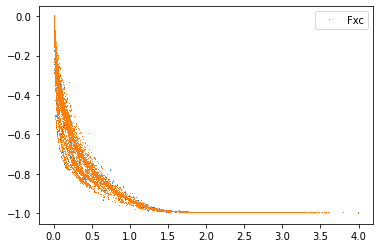

In [62]:
plot(drho, local(tdrho).cpu().detach().data,ls ='',marker=',')
plot(drho, tFxc.cpu(),ls='',marker=',',label='Fxc')
legend()
# xlim(0,3)
# xscale('log')
# yscale('log')

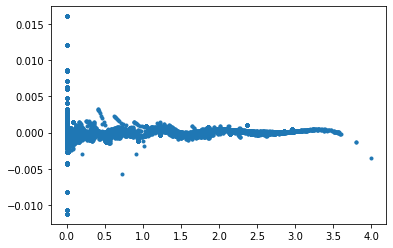

In [63]:
plot(drho, (local(tdrho).cpu()-tFxc.cpu()).detach().data,ls='',marker='.')
# plot(np.exp(drho), Fxc.detach().data)
# xscale('log')

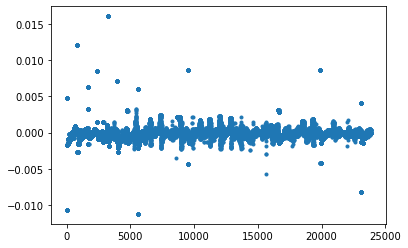

In [64]:
plot((local(tdrho).cpu()-tFxc.cpu()).detach().data,ls='',marker='.')

In [65]:
torch.save(local.state_dict(), '../models/pretrained/pbe_pw/c')

In [66]:
loc = '../models/pretrained/pbe_pw/GGA_C_PBE'

In [71]:
xc.evaluate()
xc.epsilon=1e-7

In [70]:
xc = XC(grid_models=[local], heg_mult=True, level= {'GGA':2, 'MGGA':3}[level])
xc.epsilon = 0
# if xc == 'c':
xc.loge = 1e-5

In [72]:
xc.forward = xc.eval_grid_models
traced = torch.jit.trace(xc, torch.abs(torch.rand(100,9)))
try:
    os.mkdir(loc)
except:
    pass
torch.jit.save(traced, loc +'/xc')

/home/sebastian/Research/NEURALXC/dpyscf/dpyscf/net.py:369: TracerWarning: Converting a tensor to a Python index might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  ueg_lim_a = torch.pow(self.tanh(rho[...,self.use[1]]),2)


In [1]:
import numpy as np
%pylab inline

Populating the interactive namespace from numpy and matplotlib


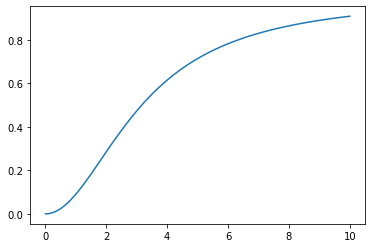

In [7]:
x = np.linspace(0,10,100)
plot(x,0.1*x**2/(1+0.1*x**2))